In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np

from src.test_calibration import SyntheticDataGenerator, Analyzer, Plotter

In [3]:
K_gt = np.array([
    [1000, 0, 480],
    [0, 1000, 640],
    [0, 0, 1]
])

n_homographies = 3
n_trials = 1000

noise_levels = np.arange(0, 0.021, 0.0025)

seed = 1234

In [4]:
generator = SyntheticDataGenerator(K_gt)

In [5]:
data = generator.generate_dataset(
    n_homographies=n_homographies,
    max_rotation=45,
    random_seed=seed
)


SYNTHETIC DATASET SUMMARY
Number of homographies: 3
Camera focal length: 1000.0
Principal point: (480.0, 640.0)
Scene Statistics
	Distance range: 0.67 - 2.17 m
	Mean distance: 1.25 ± 0.66 m
	Viewing angle range: 12.3° - 48.0°
	Mean viewing angle: 27.5° ± 15.0°

Clean Homography Statistics
	Element magnitude range: [0.0673, 1356.1005]
	Mean element magnitude: 475.5732

Dataset ready for analysis!


In [6]:
analyzer = Analyzer(data, n_trials, noise_levels)

Analyzer initialized:
	Dataset: 3 homographies
	Trials per level: 1000
	Noise levels: [0.     0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02  ]
	Image size: (960, 1280)


In [7]:
results = analyzer.run_all_analyses()

RUNNING ANALYSIS

Processing noise level σ = 0.000 (1/9)
----------------------------------------
	Calibration: f = 1000.0 ± 0.0 (error: 0.00%, success: 100.0%)
	Pixel errors: RMSE = 0.00px (2700000 measurements)

Processing noise level σ = 0.003 (2/9)
----------------------------------------
	Calibration: f = 999.2 ± 12.8 (error: 0.08%, success: 100.0%)
	Pixel errors: RMSE = 0.23px (2700000 measurements)

Processing noise level σ = 0.005 (3/9)
----------------------------------------
	Calibration: f = 998.8 ± 26.4 (error: 0.12%, success: 100.0%)
	Pixel errors: RMSE = 0.48px (2700000 measurements)

Processing noise level σ = 0.007 (4/9)
----------------------------------------
	Calibration: f = 997.3 ± 41.4 (error: 0.27%, success: 100.0%)
	Pixel errors: RMSE = 0.72px (2700000 measurements)

Processing noise level σ = 0.010 (5/9)
----------------------------------------
	Calibration: f = 997.2 ± 57.8 (error: 0.28%, success: 100.0%)
	Pixel errors: RMSE = 0.95px (2700000 measurements)

Pr

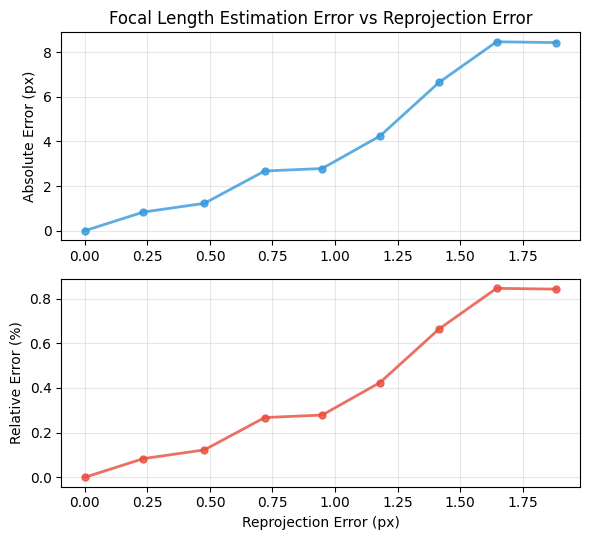

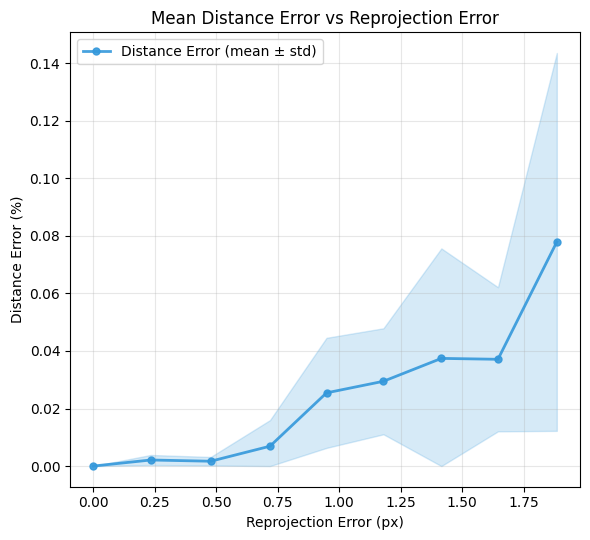

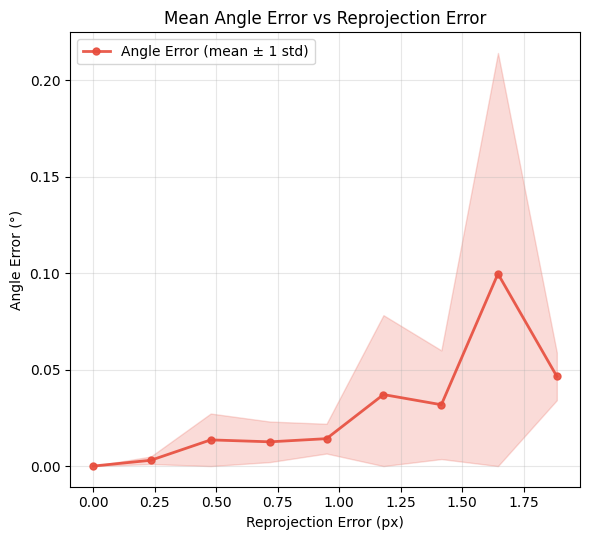

In [8]:
plotter = Plotter(data, results)
plotter.plot_all()
plotter.export_figures()